# indicators

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional
import itertools

In [3]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
])
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, 5],
    'b': [5, 4, 3, 2, 1],
    'c': [1, 2, 3, 2, 1]
}, index=index)

In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

## IndicatorFactory

In [5]:
def apply_func(i, ts, p, a, b=100):
    return ts * p[i] + a + b

@njit
def apply_func_nb(i, ts, p, a, b):
    return ts * p[i] + a + b # numba doesn't support **kwargs

# Custom function can be anything that takes time series, params and other arguments, and returns outputs
def custom_func(ts, p, *args, **kwargs):
    return vbt.base.combine_fns.apply_and_concat_one(len(p), apply_func, ts, p, *args, **kwargs)

@njit
def custom_func_nb(ts, p, *args):
    return vbt.base.combine_fns.apply_and_concat_one_nb(len(p), apply_func_nb, ts, p, *args)

print(vbt.IndicatorFactory().from_custom_func(custom_func)\
      .from_params(ts, [0, 1], 10, b=100).output)
print(vbt.IndicatorFactory().from_custom_func(custom_func_nb)\
      .from_params(ts, [0, 1], 10, 100).output)

custom_param    0              1          
                a    b    c    a    b    c
2018-01-01    110  110  110  111  115  111
2018-01-02    110  110  110  112  114  112
2018-01-03    110  110  110  113  113  113
2018-01-04    110  110  110  114  112  112
2018-01-05    110  110  110  115  111  111
custom_param    0              1          
                a    b    c    a    b    c
2018-01-01    110  110  110  111  115  111
2018-01-02    110  110  110  112  114  112
2018-01-03    110  110  110  113  113  113
2018-01-04    110  110  110  114  112  112
2018-01-05    110  110  110  115  111  111


In [6]:
# Apply function is performed on each parameter individually, and each output is then stacked for you
# Apply functions are less customizable than custom functions, but are simpler to write
def apply_func(ts, p, a, b=100):
    return ts * p + a + b

@njit
def apply_func_nb(ts, p, a, b):
    return ts * p + a + b  # numba doesn't support **kwargs
        
print(vbt.IndicatorFactory().from_apply_func(apply_func)\
      .from_params(ts, [0, 1], 10, b=100).output)
print(vbt.IndicatorFactory().from_apply_func(apply_func_nb)\
      .from_params(ts, [0, 1], 10, 100).output)

custom_param    0              1          
                a    b    c    a    b    c
2018-01-01    110  110  110  111  115  111
2018-01-02    110  110  110  112  114  112
2018-01-03    110  110  110  113  113  113
2018-01-04    110  110  110  114  112  112
2018-01-05    110  110  110  115  111  111
custom_param    0              1          
                a    b    c    a    b    c
2018-01-01    110  110  110  111  115  111
2018-01-02    110  110  110  112  114  112
2018-01-03    110  110  110  113  113  113
2018-01-04    110  110  110  114  112  112
2018-01-05    110  110  110  115  111  111


In [7]:
print(vbt.IndicatorFactory(ts_names=['ts1', 'ts2']).from_apply_func(lambda ts1, ts2, p: ts1 * ts2 * p)\
      .from_params(ts, ts+1, [0, 1]).output) # test multiple ts
print(vbt.IndicatorFactory(ts_names=['ts1', 'ts2']).from_apply_func(njit(lambda ts1, ts2, p: ts1 * ts2 * p))\
      .from_params(ts, ts+1, [0, 1]).output)

custom_param  0         1        
              a  b  c   a   b   c
2018-01-01    0  0  0   2  30   2
2018-01-02    0  0  0   6  20   6
2018-01-03    0  0  0  12  12  12
2018-01-04    0  0  0  20   6   6
2018-01-05    0  0  0  30   2   2
custom_param  0         1        
              a  b  c   a   b   c
2018-01-01    0  0  0   2  30   2
2018-01-02    0  0  0   6  20   6
2018-01-03    0  0  0  12  12  12
2018-01-04    0  0  0  20   6   6
2018-01-05    0  0  0  30   2   2


In [8]:
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))\
      .from_params(ts, [0, 1], [2, 3]).output) # test multiple params
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))\
      .from_params(ts, [0, 1], [2, 3]).output)

custom_p1    0          1        
custom_p2    2          3        
             a   b  c   a   b   c
2018-01-01   2  10  2   4  20   4
2018-01-02   4   8  4   8  16   8
2018-01-03   6   6  6  12  12  12
2018-01-04   8   4  4  16   8   8
2018-01-05  10   2  2  20   4   4
custom_p1    0          1        
custom_p2    2          3        
             a   b  c   a   b   c
2018-01-01   2  10  2   4  20   4
2018-01-02   4   8  4   8  16   8
2018-01-03   6   6  6  12  12  12
2018-01-04   8   4  4  16   8   8
2018-01-05  10   2  2  20   4   4


In [9]:
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))\
      .from_params(ts, [0, 1], [2, 3], param_product=True).output) # test param product
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))\
      .from_params(ts, [0, 1], [2, 3], param_product=True).output)

custom_p1    0                     1                   
custom_p2    2          3          2          3        
             a   b  c   a   b  c   a   b  c   a   b   c
2018-01-01   2  10  2   3  15  3   3  15  3   4  20   4
2018-01-02   4   8  4   6  12  6   6  12  6   8  16   8
2018-01-03   6   6  6   9   9  9   9   9  9  12  12  12
2018-01-04   8   4  4  12   6  6  12   6  6  16   8   8
2018-01-05  10   2  2  15   3  3  15   3  3  20   4   4
custom_p1    0                     1                   
custom_p2    2          3          2          3        
             a   b  c   a   b  c   a   b  c   a   b   c
2018-01-01   2  10  2   3  15  3   3  15  3   4  20   4
2018-01-02   4   8  4   6  12  6   6  12  6   8  16   8
2018-01-03   6   6  6   9   9  9   9   9  9  12  12  12
2018-01-04   8   4  4  12   6  6  12   6  6  16   8   8
2018-01-05  10   2  2  15   3  3  15   3  3  20   4   4


In [10]:
vbt.IndicatorFactory(output_names=['o1', 'o2']).from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))\
      .from_params(ts, [0, 1]).o2.values

array([[0, 0, 0, 1, 5, 1],
       [0, 0, 0, 2, 4, 2],
       [0, 0, 0, 3, 3, 3],
       [0, 0, 0, 4, 2, 2],
       [0, 0, 0, 5, 1, 1]])

In [11]:
print(vbt.IndicatorFactory(output_names=['o1', 'o2']).from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))\
      .from_params(ts, [0, 1]).o1) # test multiple outputs
print(vbt.IndicatorFactory(output_names=['o1', 'o2']).from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))\
      .from_params(ts, [0, 1]).o2)
print(vbt.IndicatorFactory(output_names=['o1', 'o2']).from_apply_func(njit(lambda ts, p: (ts * p, ts * p ** 2)))\
      .from_params(ts, [0, 1]).o1)
print(vbt.IndicatorFactory(output_names=['o1', 'o2']).from_apply_func(njit(lambda ts, p: (ts * p, ts * p ** 2)))\
      .from_params(ts, [0, 1]).o2)

custom_param  0        1      
              a  b  c  a  b  c
2018-01-01    0  0  0  1  5  1
2018-01-02    0  0  0  2  4  2
2018-01-03    0  0  0  3  3  3
2018-01-04    0  0  0  4  2  2
2018-01-05    0  0  0  5  1  1
custom_param  0        1      
              a  b  c  a  b  c
2018-01-01    0  0  0  1  5  1
2018-01-02    0  0  0  2  4  2
2018-01-03    0  0  0  3  3  3
2018-01-04    0  0  0  4  2  2
2018-01-05    0  0  0  5  1  1
custom_param  0        1      
              a  b  c  a  b  c
2018-01-01    0  0  0  1  5  1
2018-01-02    0  0  0  2  4  2
2018-01-03    0  0  0  3  3  3
2018-01-04    0  0  0  4  2  2
2018-01-05    0  0  0  5  1  1
custom_param  0        1      
              a  b  c  a  b  c
2018-01-01    0  0  0  1  5  1
2018-01-02    0  0  0  2  4  2
2018-01-03    0  0  0  3  3  3
2018-01-04    0  0  0  4  2  2
2018-01-05    0  0  0  5  1  1


In [12]:
print(vbt.IndicatorFactory().from_apply_func(lambda ts, p, a: ts * p + a)\
      .from_params(ts, [0, 1, 2], 3).output) # test *args
print(vbt.IndicatorFactory().from_apply_func(njit(lambda ts, p, a: ts * p + a))\
      .from_params(ts, [0, 1, 2], 3).output)

custom_param  0        1         2       
              a  b  c  a  b  c   a   b  c
2018-01-01    3  3  3  4  8  4   5  13  5
2018-01-02    3  3  3  5  7  5   7  11  7
2018-01-03    3  3  3  6  6  6   9   9  9
2018-01-04    3  3  3  7  5  5  11   7  7
2018-01-05    3  3  3  8  4  4  13   5  5
custom_param  0        1         2       
              a  b  c  a  b  c   a   b  c
2018-01-01    3  3  3  4  8  4   5  13  5
2018-01-02    3  3  3  5  7  5   7  11  7
2018-01-03    3  3  3  6  6  6   9   9  9
2018-01-04    3  3  3  7  5  5  11   7  7
2018-01-05    3  3  3  8  4  4  13   5  5


In [13]:
print(vbt.IndicatorFactory().from_apply_func(lambda ts, p, a=1: ts * p + a)\
      .from_params(ts, [0, 1, 2], a=3).output) # test **kwargs
# Numba doesn't support kwargs out of the box

custom_param  0        1         2       
              a  b  c  a  b  c   a   b  c
2018-01-01    3  3  3  4  8  4   5  13  5
2018-01-02    3  3  3  5  7  5   7  11  7
2018-01-03    3  3  3  6  6  6   9   9  9
2018-01-04    3  3  3  7  5  5  11   7  7
2018-01-05    3  3  3  8  4  4  13   5  5


In [14]:
print(vbt.IndicatorFactory().from_apply_func(
    lambda ts, param, c: ts * param + c, caching_func=lambda ts, params: 100)\
      .from_params(ts, [0, 1]).output) # test caching func
print(vbt.IndicatorFactory().from_apply_func(
    njit(lambda ts, param, c: ts * param + c), caching_func=njit(lambda ts, params: 100))\
      .from_params(ts, [0, 1]).output)

custom_param    0              1          
                a    b    c    a    b    c
2018-01-01    100  100  100  101  105  101
2018-01-02    100  100  100  102  104  102
2018-01-03    100  100  100  103  103  103
2018-01-04    100  100  100  104  102  102
2018-01-05    100  100  100  105  101  101
custom_param    0              1          
                a    b    c    a    b    c
2018-01-01    100  100  100  101  105  101
2018-01-02    100  100  100  102  104  102
2018-01-03    100  100  100  103  103  103
2018-01-04    100  100  100  104  102  102
2018-01-05    100  100  100  105  101  101


In [15]:
CustomInd = vbt.IndicatorFactory(
    ts_names=['ts1', 'ts2'],
    param_names=['p1', 'p2'],
    output_names=['o1', 'o2']
).from_apply_func(lambda ts1, ts2, p1, p2: (ts1 * p1, ts2 * p2))

In [16]:
dir(CustomInd) # you can list here all of the available tools

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'from_params',
 'iloc',
 'loc',
 'name',
 'o1',
 'o1_above',
 'o1_below',
 'o1_equal',
 'o2',
 'o2_above',
 'o2_below',
 'o2_equal',
 'p1_loc',
 'p2_loc',
 'ts1',
 'ts1_above',
 'ts1_below',
 'ts1_equal',
 'ts2',
 'ts2_above',
 'ts2_below',
 'ts2_equal',
 'tuple_loc',
 'xs']

In [17]:
custom_ind = CustomInd.from_params(ts, ts * 2, [1, 2], [3, 4])
big_custom_ind = CustomInd.from_params(big_ts, big_ts * 2, [1, 2], [3, 4])

In [18]:
print(custom_ind.wrapper.index) # subclasses ArrayWrapper
print(custom_ind.wrapper.columns)
print(custom_ind.wrapper.ndim)
print(custom_ind.wrapper.shape)
print(custom_ind.wrapper.freq)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq=None)
MultiIndex([(1, 3, 'a'),
            (1, 3, 'b'),
            (1, 3, 'c'),
            (2, 4, 'a'),
            (2, 4, 'b'),
            (2, 4, 'c')],
           names=['custom_p1', 'custom_p2', None])
2
(5, 6)
1 days 00:00:00


### Pandas indexing

In [19]:
print(custom_ind.o1.iloc[:, 0])
%timeit big_custom_ind.o1.iloc[:, 0] # benchmark, 1 column

print(custom_ind.iloc[:, 0].o1) # performed on the object itself
%timeit big_custom_ind.iloc[:, 0] # slower since it forwards the operation to each dataframe

2018-01-01    1
2018-01-02    2
2018-01-03    3
2018-01-04    4
2018-01-05    5
Name: (1, 3, a), dtype: int64
79.7 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2018-01-01    1
2018-01-02    2
2018-01-03    3
2018-01-04    4
2018-01-05    5
Name: (1, 3, a), dtype: int64
11.9 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(custom_ind.o1.iloc[:, np.arange(3)])
%timeit big_custom_ind.o1.iloc[:, np.arange(1000)] # 1000 columns

print(custom_ind.iloc[:, np.arange(3)].o1)
%timeit big_custom_ind.iloc[:, np.arange(1000)]

custom_p1   1      
custom_p2   3      
            a  b  c
2018-01-01  1  5  1
2018-01-02  2  4  2
2018-01-03  3  3  3
2018-01-04  4  2  2
2018-01-05  5  1  1
2.82 ms ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
custom_p1   1      
custom_p2   3      
            a  b  c
2018-01-01  1  5  1
2018-01-02  2  4  2
2018-01-03  3  3  3
2018-01-04  4  2  2
2018-01-05  5  1  1
31 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
print(custom_ind.o1.loc[:, (1, 3, 'a')])
%timeit big_custom_ind.o1.loc[:, (1, 3, 0)] # 1 column

print(custom_ind.loc[:, (1, 3, 'a')].o1)
%timeit big_custom_ind.loc[:, (1, 3, 0)]

2018-01-01    1
2018-01-02    2
2018-01-03    3
2018-01-04    4
2018-01-05    5
Name: (1, 3, a), dtype: int64
79.3 µs ± 572 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2018-01-01    1
2018-01-02    2
2018-01-03    3
2018-01-04    4
2018-01-05    5
Name: (1, 3, a), dtype: int64
12.4 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
print(custom_ind.o1.loc[:, (1, 3)])
%timeit big_custom_ind.o1.loc[:, 1] # 1000 columns

print(custom_ind.loc[:, (1, 3)].o1)
%timeit big_custom_ind.loc[:, 1]

            a  b  c
2018-01-01  1  5  1
2018-01-02  2  4  2
2018-01-03  3  3  3
2018-01-04  4  2  2
2018-01-05  5  1  1
370 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
            a  b  c
2018-01-01  1  5  1
2018-01-02  2  4  2
2018-01-03  3  3  3
2018-01-04  4  2  2
2018-01-05  5  1  1
10.9 ms ± 87.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
print(custom_ind.o1.xs(1, axis=1, level=0))
%timeit big_custom_ind.o1.xs(1, axis=1, level=0) # 1000 columns

print(custom_ind.xs(1, axis=1, level=0).o1)
%timeit big_custom_ind.xs(1, axis=1, level=0)

custom_p2   3      
            a  b  c
2018-01-01  1  5  1
2018-01-02  2  4  2
2018-01-03  3  3  3
2018-01-04  4  2  2
2018-01-05  5  1  1
391 µs ± 3.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_p2   3      
            a  b  c
2018-01-01  1  5  1
2018-01-02  2  4  2
2018-01-03  3  3  3
2018-01-04  4  2  2
2018-01-05  5  1  1
11.1 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Parameter indexing

In [24]:
# Indexing by parameter
print(custom_ind._p1_mapper)
print(custom_ind.p1_loc[2].o1)
print(custom_ind.p1_loc[1:2].o1)
print(custom_ind.p1_loc[[1, 1, 1]].o1)

custom_p1  custom_p2   
1          3          a    1
                      b    1
                      c    1
2          4          a    2
                      b    2
                      c    2
Name: custom_p1, dtype: int64
custom_p2    4       
             a   b  c
2018-01-01   2  10  2
2018-01-02   4   8  4
2018-01-03   6   6  6
2018-01-04   8   4  4
2018-01-05  10   2  2
custom_p1   1         2       
custom_p2   3         4       
            a  b  c   a   b  c
2018-01-01  1  5  1   2  10  2
2018-01-02  2  4  2   4   8  4
2018-01-03  3  3  3   6   6  6
2018-01-04  4  2  2   8   4  4
2018-01-05  5  1  1  10   2  2
custom_p1   1                        
custom_p2   3                        
            a  b  c  a  b  c  a  b  c
2018-01-01  1  5  1  1  5  1  1  5  1
2018-01-02  2  4  2  2  4  2  2  4  2
2018-01-03  3  3  3  3  3  3  3  3  3
2018-01-04  4  2  2  4  2  2  4  2  2
2018-01-05  5  1  1  5  1  1  5  1  1


In [25]:
%timeit big_custom_ind.p1_loc[1] # 1000 columns
%timeit big_custom_ind.p1_loc[np.full(10, 1)] # 10000 columns

31.4 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
210 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print(custom_ind._tuple_mapper)
print(custom_ind.tuple_loc[(1, 3)].o1)
print(custom_ind.tuple_loc[(1, 3):(2, 4)].o1)

custom_p1  custom_p2   
1          3          a    (1, 3)
                      b    (1, 3)
                      c    (1, 3)
2          4          a    (2, 4)
                      b    (2, 4)
                      c    (2, 4)
Name: (custom_p1, custom_p2), dtype: object
            a  b  c
2018-01-01  1  5  1
2018-01-02  2  4  2
2018-01-03  3  3  3
2018-01-04  4  2  2
2018-01-05  5  1  1
custom_p1   1         2       
custom_p2   3         4       
            a  b  c   a   b  c
2018-01-01  1  5  1   2  10  2
2018-01-02  2  4  2   4   8  4
2018-01-03  3  3  3   6   6  6
2018-01-04  4  2  2   8   4  4
2018-01-05  5  1  1  10   2  2


In [27]:
%timeit big_custom_ind.tuple_loc[(1, 3)]
%timeit big_custom_ind.tuple_loc[[(1, 3)] * 10]

27.8 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
212 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Comparison methods

In [28]:
print(custom_ind.o1 > 2)
%timeit big_custom_ind.o1.values > 2 # don't even try pandas

print(custom_ind.o1_above(2))
%timeit big_custom_ind.o1_above(2) # slower than numpy because of constructing dataframe

custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False   True  False  False   True  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True  False  False   True   True   True
2018-01-05   True  False  False   True  False  False
1.31 ms ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False   True  False  False   True  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True  False  False   True   True   True
2018-01-05   True  False  False   True  False  False
3.99 ms ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(pd.concat((custom_ind.o1 > 2, custom_ind.o1 > 3), axis=1))
%timeit np.hstack((big_custom_ind.o1.values > 2, big_custom_ind.o1.values > 3))

print(custom_ind.o1_above([2, 3], multiple=True))
%timeit big_custom_ind.o1_above([2, 3], multiple=True)

custom_p1       1                    2                    1                \
custom_p2       3                    4                    3                 
                a      b      c      a      b      c      a      b      c   
2018-01-01  False   True  False  False   True  False  False   True  False   
2018-01-02  False   True  False   True   True   True  False   True  False   
2018-01-03   True   True   True   True   True   True  False  False  False   
2018-01-04   True  False  False   True   True   True   True  False  False   
2018-01-05   True  False  False   True  False  False   True  False  False   

custom_p1       2                
custom_p2       4                
                a      b      c  
2018-01-01  False   True  False  
2018-01-02   True   True   True  
2018-01-03   True   True   True  
2018-01-04   True   True   True  
2018-01-05   True  False  False  
3.91 ms ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
custom_o1_above      2                 

## MA

In [30]:
print(vbt.MA.from_params(ts['a'], 2).ma)
print(vbt.MA.from_params(ts, 2).ma)
print(vbt.MA.from_params(ts, [2, 3], ewm=False).ma)
print(vbt.MA.from_params(ts, [2, 3], ewm=[False, True]).ma)
print(vbt.MA.from_params(ts, [2, 3], ewm=[False, True], param_product=True).ma)

2018-01-01    NaN
2018-01-02    1.5
2018-01-03    2.5
2018-01-04    3.5
2018-01-05    4.5
Name: (2, False, a), dtype: float64
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  4.5  1.5
2018-01-03  2.5  3.5  2.5
2018-01-04  3.5  2.5  2.5
2018-01-05  4.5  1.5  1.5
ma_window      2               3               
ma_ewm     False           False               
               a    b    c     a    b         c
2018-01-01   NaN  NaN  NaN   NaN  NaN       NaN
2018-01-02   1.5  4.5  1.5   NaN  NaN       NaN
2018-01-03   2.5  3.5  2.5   2.0  4.0  2.000000
2018-01-04   3.5  2.5  2.5   3.0  3.0  2.333333
2018-01-05   4.5  1.5  1.5   4.0  2.0  2.000000
ma_window      2                   3                    
ma_ewm     False               True                     
               a    b    c         a         b         c
2018-01-01   NaN  NaN  NaN       NaN       NaN       NaN
2018-01-02   1.5  4.5  1.5       NaN       NaN       NaN
2018-01-03   2.5  3.5  2.5  2.428571  3.571429  2

In [31]:
# One window
%timeit big_ts.rolling(2).mean() # pandas
%timeit vbt.MA.from_params(big_ts, 2, return_cache=True) # cache only
%timeit vbt.MA.from_params(big_ts, 2) # with pre+postprocessing and still beats pandas

print(vbt.MA.from_params(big_ts, 2).ma.shape)

29.2 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.2 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.7 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [32]:
# Multiple windows
%timeit pd.concat([big_ts.rolling(i).mean() for i in np.arange(2, 100)])
%timeit vbt.MA.from_params(big_ts, np.arange(2, 100), return_cache=True) # cache only
%timeit vbt.MA.from_params(big_ts, np.arange(2, 100))
cache = vbt.MA.from_params(big_ts, np.arange(2, 100), return_cache=True)
%timeit vbt.MA.from_params(big_ts, np.arange(2, 100), cache=cache) # using cache

print(vbt.MA.from_params(big_ts, np.arange(2, 100)).ma.shape)

3.47 s ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.61 s ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.62 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
976 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [33]:
# One window repeated
%timeit pd.concat([big_ts.rolling(i).mean() for i in np.full(100, 2)])
%timeit vbt.MA.from_params(big_ts, np.full(100, 2), return_cache=True)
%timeit vbt.MA.from_params(big_ts, np.full(100, 2))

print(vbt.MA.from_params(big_ts, np.full(100, 2)).ma.shape)

3.66 s ± 91.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.6 ms ± 93.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.01 s ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [34]:
ma = vbt.MA.from_params(ts, [2, 3], ewm=[False, True])
big_ma = vbt.MA.from_params(big_ts, np.arange(2, 100), ewm=False)

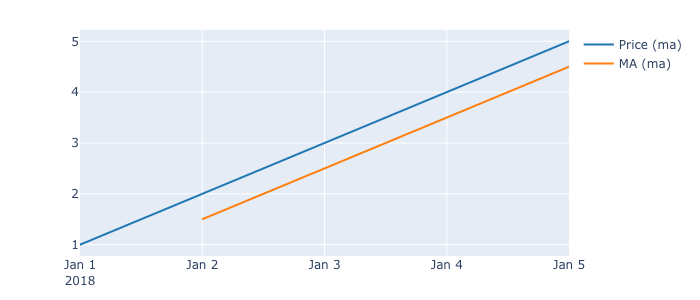

In [35]:
ma[(2, False, 'a')].plot().show_png()

### Combinations

In [36]:
comb = itertools.combinations(np.arange(2, 20), 2)
fast_windows, slow_windows = np.asarray(list(comb)).transpose()
print(fast_windows, slow_windows)

%timeit vbt.MA.from_params(big_ts, fast_windows), vbt.MA.from_params(big_ts, slow_windows) # naive way
%timeit vbt.MA.from_combs(big_ts, np.arange(2, 20), 2) # performs caching -> a bit faster

[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6
  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 11 11 11
 11 11 11 11 11 12 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 15
 15 15 15 16 16 16 17 17 18] [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  6  7  8  9 10 11 12 13 14 15 16 17 18 19  7  8  9 10 11 12 13 14 15 16
 17 18 19  8  9 10 11 12 13 14 15 16 17 18 19  9 10 11 12 13 14 15 16 17
 18 19 10 11 12 13 14 15 16 17 18 19 11 12 13 14 15 16 17 18 19 12 13 14
 15 16 17 18 19 13 14 15 16 17 18 19 14 15 16 17 18 19 15 16 17 18 19 16
 17 18 19 17 18 19 18 19 19]
4.68 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [37]:
ma1, ma2 = vbt.MA.from_combs(ts, [2, 3, 4], 2, ewm=[False, False, True])

print(ma1.ma)
print(ma2.ma)

ma1_window     2                              3               
ma1_ewm    False                          False               
               a    b    c    a    b    c     a    b         c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN       NaN
2018-01-02   1.5  4.5  1.5  1.5  4.5  1.5   NaN  NaN       NaN
2018-01-03   2.5  3.5  2.5  2.5  3.5  2.5   2.0  4.0  2.000000
2018-01-04   3.5  2.5  2.5  3.5  2.5  2.5   3.0  3.0  2.333333
2018-01-05   4.5  1.5  1.5  4.5  1.5  1.5   4.0  2.0  2.000000
ma2_window     3                        4                                \
ma2_ewm    False                    True                                  
               a    b         c         a         b         c         a   
2018-01-01   NaN  NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-02   NaN  NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-03   2.0  4.0  2.000000       NaN       NaN       NaN       NaN   
2018-01-04   3.0  3.0  2.333333  3.095588  2.9

In [38]:
print(ma1.ma_above(ma2, crossed=True))
print(ma1.ma_below(ma2, crossed=True))

ma1_window      2                                         3              
ma1_ewm     False                                     False              
ma2_window      3                    4                    4              
ma2_ewm     False                True                 True               
                a      b      c      a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False  False  False  False
2018-01-03   True  False   True  False  False  False  False  False  False
2018-01-04  False  False  False   True  False   True  False   True   True
2018-01-05  False  False  False  False  False  False   True  False  False
ma1_window      2                                         3              
ma1_ewm     False                                     False              
ma2_window      3                    4                    4              
ma2_ewm     False                True 

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:413: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:413: RuntimeWarning:

invalid value encountered in less



## MSTD

In [39]:
print(vbt.MSTD.from_params(ts['a'], 2).mstd)
print(vbt.MSTD.from_params(ts, 2).mstd)
print(vbt.MSTD.from_params(ts, [2, 3], ewm=False).mstd)
print(vbt.MSTD.from_params(ts, [2, 3], ewm=[False, True]).mstd)
print(vbt.MSTD.from_params(ts, [2, 3], ewm=[False, True], param_product=True).mstd)

2018-01-01         NaN
2018-01-02    0.707107
2018-01-03    0.707107
2018-01-04    0.707107
2018-01-05    0.707107
Name: (2, False, a), dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107  0.707107  0.707107
2018-01-03  0.707107  0.707107  0.707107
2018-01-04  0.707107  0.707107  0.707107
2018-01-05  0.707107  0.707107  0.707107
mstd_window         2                         3              
mstd_ewm        False                     False              
                    a         b         c     a    b        c
2018-01-01        NaN       NaN       NaN   NaN  NaN      NaN
2018-01-02   0.707107  0.707107  0.707107   NaN  NaN      NaN
2018-01-03   0.707107  0.707107  0.707107   1.0  1.0  1.00000
2018-01-04   0.707107  0.707107  0.707107   1.0  1.0  0.57735
2018-01-05   0.707107  0.707107  0.707107   1.0  1.0  1.00000
mstd_window         2                             3                    
mstd_ewm        False              

In [40]:
# One window
%timeit big_ts.rolling(2).std()
%timeit vbt.MSTD.from_params(big_ts, 2)

print(vbt.MSTD.from_params(big_ts, 2).mstd.shape)

53.7 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.3 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [41]:
# Multiple windows
%timeit pd.concat([big_ts.rolling(i).std() for i in np.arange(2, 100)])
%timeit vbt.MSTD.from_params(big_ts, np.arange(2, 100))

print(vbt.MSTD.from_params(big_ts, np.arange(2, 100)).mstd.shape)

5.98 s ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.87 s ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [42]:
# One window repeated
%timeit vbt.MA.from_params(big_ts, np.full(100, 2))

print(vbt.MSTD.from_params(big_ts, np.full(100, 2)).mstd.shape)

993 ms ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [43]:
mstd = vbt.MSTD.from_params(ts, [2, 3], [False, True])

print(mstd.mstd)

mstd_window         2                             3                    
mstd_ewm        False                         True                     
                    a         b         c         a         b         c
2018-01-01        NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02   0.707107  0.707107  0.707107       NaN       NaN       NaN
2018-01-03   0.707107  0.707107  0.707107  0.963624  0.963624  0.963624
2018-01-04   0.707107  0.707107  0.707107  1.177164  1.177164  0.686607
2018-01-05   0.707107  0.707107  0.707107  1.345243  1.345243  0.881714


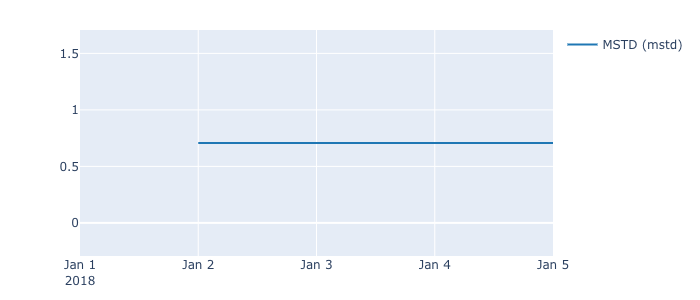

In [44]:
mstd[(2, False, 'a')].plot().show_png()

## BollingerBands

In [45]:
print(vbt.BollingerBands.from_params(ts, window=2, alpha=1).middle)
print(vbt.BollingerBands.from_params(ts, window=[2, 3], ewm=False, alpha=1.5).middle)
print(vbt.BollingerBands.from_params(ts, window=[2, 3], ewm=[False, True], alpha=[1, 2]).middle)
print(vbt.BollingerBands.from_params(ts, window=[2, 3], ewm=[False, True], alpha=[1, 2], param_product=True).middle)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  4.5  1.5
2018-01-03  2.5  3.5  2.5
2018-01-04  3.5  2.5  2.5
2018-01-05  4.5  1.5  1.5
bb_window      2               3               
bb_ewm     False           False               
bb_alpha     1.5             1.5               
               a    b    c     a    b         c
2018-01-01   NaN  NaN  NaN   NaN  NaN       NaN
2018-01-02   1.5  4.5  1.5   NaN  NaN       NaN
2018-01-03   2.5  3.5  2.5   2.0  4.0  2.000000
2018-01-04   3.5  2.5  2.5   3.0  3.0  2.333333
2018-01-05   4.5  1.5  1.5   4.0  2.0  2.000000
bb_window      2                   3                    
bb_ewm     False               True                     
bb_alpha     1.0                 2.0                    
               a    b    c         a         b         c
2018-01-01   NaN  NaN  NaN       NaN       NaN       NaN
2018-01-02   1.5  4.5  1.5       NaN       NaN       NaN
2018-01-03   2.5  3.5  2.5  2.428571  3.571429  2.428571
2018-01-04   

In [46]:
# One window
%timeit vbt.BollingerBands.from_params(big_ts)

print(vbt.BollingerBands.from_params(big_ts).ts.shape)

54.3 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [47]:
# Multiple windows
%timeit vbt.BollingerBands.from_params(big_ts, window=np.arange(2, 100))

print(vbt.BollingerBands.from_params(big_ts, window=np.arange(2, 100)).ts.shape)

6.37 s ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [48]:
# One window repeated
%timeit vbt.BollingerBands.from_params(big_ts, window=np.full(100, 2))

print(vbt.BollingerBands.from_params(big_ts, window=np.full(100, 2)).ts.shape)

2.89 s ± 84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [49]:
bb = vbt.BollingerBands.from_params(ts, window=2, alpha=[1., 2.], ewm=False)

print(bb.middle)
print()
print(bb.upper)
print()
print(bb.lower)
print()
print(bb.percent_b)
print()
print(bb.bandwidth)

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-02   1.5  4.5  1.5  1.5  4.5  1.5
2018-01-03   2.5  3.5  2.5  2.5  3.5  2.5
2018-01-04   3.5  2.5  2.5  3.5  2.5  2.5
2018-01-05   4.5  1.5  1.5  4.5  1.5  1.5

bb_window          2                                                  
bb_ewm         False                                                  
bb_alpha         1.0                           2.0                    
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02  2.207107  5.207107  2.207107  2.914214  5.914214  2.914214
2018-01-03  3.207107  4.207107  3.207107  3.914214  4.914214  3.914214
2018-01-04  4.207107  3.207107  3.207107  4.914214  3.914214  3.914214
2018-01-05  5.207107  2.207107  2.207107  5.914214  2

In [50]:
print(bb.ts_below(bb.upper) & bb.ts_above(bb.lower)) # price between bands

bb_window       2                                   
bb_ewm      False                                   
bb_alpha      1.0                  2.0              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02   True   True   True   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True   True   True   True   True   True
2018-01-05   True   True   True   True   True   True


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:413: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:413: RuntimeWarning:

invalid value encountered in greater



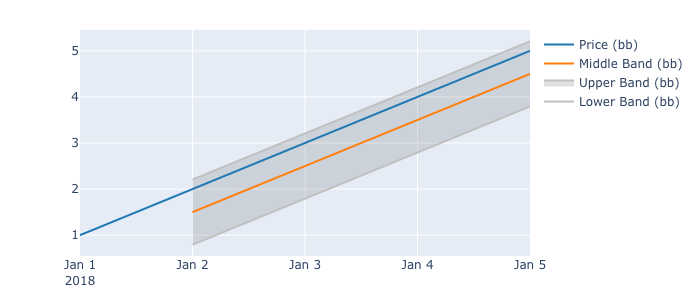

In [51]:
bb[(2, False, 1., 'a')].plot().show_png()

## RSI

In [52]:
print(vbt.RSI.from_params(ts['a'], window=2).rsi)
print(vbt.RSI.from_params(ts, window=2).rsi)
print(vbt.RSI.from_params(ts, window=[2, 3], ewm=False).rsi)
print(vbt.RSI.from_params(ts, window=[2, 3], ewm=[False, True]).rsi)
print(vbt.RSI.from_params(ts, window=[2, 3], ewm=[False, True], param_product=True).rsi)

2018-01-01      NaN
2018-01-02      NaN
2018-01-03    100.0
2018-01-04    100.0
2018-01-05    100.0
Name: (2, False, a), dtype: float64
                a    b      c
2018-01-01    NaN  NaN    NaN
2018-01-02    NaN  NaN    NaN
2018-01-03  100.0  0.0  100.0
2018-01-04  100.0  0.0   50.0
2018-01-05  100.0  0.0    0.0
rsi_window      2                  3                
rsi_ewm     False              False                
                a    b      c      a    b          c
2018-01-01    NaN  NaN    NaN    NaN  NaN        NaN
2018-01-02    NaN  NaN    NaN    NaN  NaN        NaN
2018-01-03  100.0  0.0  100.0    NaN  NaN        NaN
2018-01-04  100.0  0.0   50.0  100.0  0.0  66.666667
2018-01-05  100.0  0.0    0.0  100.0  0.0  33.333333
rsi_window      2                  3                
rsi_ewm     False              True                 
                a    b      c      a    b          c
2018-01-01    NaN  NaN    NaN    NaN  NaN        NaN
2018-01-02    NaN  NaN    NaN    NaN  NaN       

In [53]:
# One window
%timeit vbt.RSI.from_params(big_ts, window=2)

print(vbt.RSI.from_params(big_ts, window=2).rsi.shape)

67.5 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [54]:
# Multiple windows
%timeit vbt.RSI.from_params(big_ts, window=np.arange(2, 100))

print(vbt.RSI.from_params(big_ts, window=np.arange(2, 100)).rsi.shape)

4.95 s ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [55]:
# One window repeated
%timeit vbt.RSI.from_params(big_ts, window=np.full(100, 2))

print(vbt.RSI.from_params(big_ts, window=np.full(100, 2)).rsi.shape)

1.4 s ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [56]:
rsi = vbt.RSI.from_params(ts, window=[2, 3], ewm=[False, True])

print(rsi.rsi)

rsi_window      2                  3                
rsi_ewm     False              True                 
                a    b      c      a    b          c
2018-01-01    NaN  NaN    NaN    NaN  NaN        NaN
2018-01-02    NaN  NaN    NaN    NaN  NaN        NaN
2018-01-03  100.0  0.0  100.0    NaN  NaN        NaN
2018-01-04  100.0  0.0   50.0  100.0  0.0  42.857143
2018-01-05  100.0  0.0    0.0  100.0  0.0  20.000000


In [57]:
print(rsi.rsi_above(70))

rsi_window      2                    3              
rsi_ewm     False                True               
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03   True  False   True  False  False  False
2018-01-04   True  False  False   True  False  False
2018-01-05   True  False  False   True  False  False


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:413: RuntimeWarning:

invalid value encountered in greater



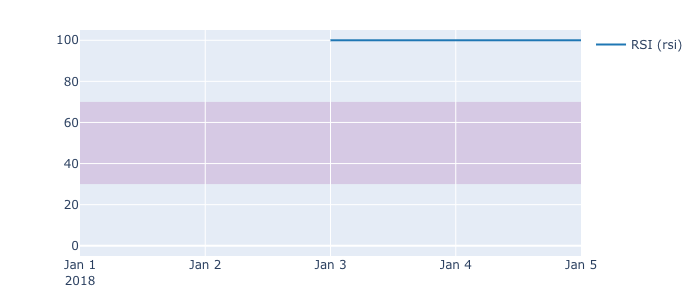

In [58]:
rsi[(2, False, 'a')].plot().show_png()

## Stochastic

In [59]:
print(vbt.Stochastic.from_params(ts['a'], k_window=2, d_window=3, d_ewm=False).percent_d)
print(vbt.Stochastic.from_params(ts['a'], high_ts=ts['a']*1.1, low_ts=ts['a']*0.9, k_window=2, d_window=3).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=2, d_window=3).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=2, d_window=[2, 3]).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=[2, 3], d_window=[2, 3]).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=[2, 3], d_window=[2, 3], param_product=True).percent_d)

2018-01-01      NaN
2018-01-02      NaN
2018-01-03      NaN
2018-01-04    100.0
2018-01-05    100.0
Name: (2, 3, False, a), dtype: float64
2018-01-01          NaN
2018-01-02          NaN
2018-01-03          NaN
2018-01-04    80.361991
2018-01-05    76.718266
Name: (2, 3, False, a), dtype: float64
                a    b          c
2018-01-01    NaN  NaN        NaN
2018-01-02    NaN  NaN        NaN
2018-01-03    NaN  NaN        NaN
2018-01-04  100.0  0.0  66.666667
2018-01-05  100.0  0.0  33.333333
stoch_k_window      2                                   
stoch_d_window      2                  3                
stoch_d_ewm     False              False                
                    a    b      c      a    b          c
2018-01-01        NaN  NaN    NaN    NaN  NaN        NaN
2018-01-02        NaN  NaN    NaN    NaN  NaN        NaN
2018-01-03      100.0  0.0  100.0    NaN  NaN        NaN
2018-01-04      100.0  0.0   50.0  100.0  0.0  66.666667
2018-01-05      100.0  0.0    0.0  100.0  

In [60]:
# One window
%timeit vbt.Stochastic.from_params(big_ts, k_window=2)

print(vbt.Stochastic.from_params(big_ts, k_window=2).percent_d.shape)

59.2 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [61]:
# Multiple windows
%timeit vbt.Stochastic.from_params(big_ts, k_window=np.arange(2, 100)) # rolling min/max very expensive

print(vbt.Stochastic.from_params(big_ts, k_window=np.arange(2, 100)).percent_d.shape)

24.8 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [62]:
# One window repeated
%timeit vbt.Stochastic.from_params(big_ts, k_window=np.full(100, 2))

print(vbt.Stochastic.from_params(big_ts, k_window=np.full(100, 2)).percent_d.shape)

4.08 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [63]:
stochastic = vbt.Stochastic.from_params(
    ts, high_ts=ts*1.1, low_ts=ts*0.9, k_window=[2, 4], d_window=2, d_ewm=[False, True])

print(stochastic.percent_k)
print(stochastic.percent_d)

stoch_k_window          2                                4            \
stoch_d_window          2                                2             
stoch_d_ewm         False                            True              
                        a          b          c          a         b   
2018-01-01            NaN        NaN        NaN        NaN       NaN   
2018-01-02      84.615385  21.052632  84.615385        NaN       NaN   
2018-01-03      80.000000  17.647059  80.000000        NaN       NaN   
2018-01-04      76.470588  13.333333  13.333333  88.571429  5.405405   
2018-01-05      73.684211   7.692308   7.692308  86.486486  2.857143   

stoch_k_window             
stoch_d_window             
stoch_d_ewm                
                        c  
2018-01-01            NaN  
2018-01-02            NaN  
2018-01-03            NaN  
2018-01-04      45.833333  
2018-01-05       4.166667  
stoch_k_window          2                                4            \
stoch_d_window          2  

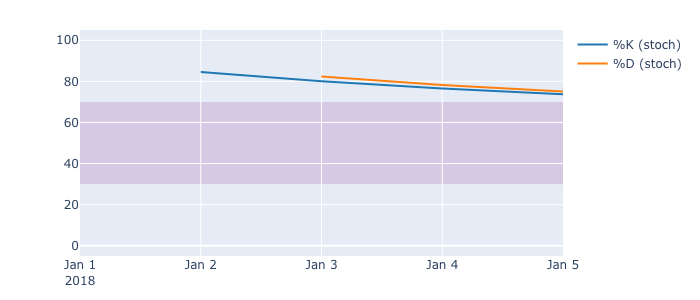

In [64]:
stochastic[(2, 2, False, 'a')].plot().show_png()

## MACD

In [65]:
print(vbt.MACD.from_params(ts['a'], fast_window=2, slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=True).signal)
print(vbt.MACD.from_params(ts, fast_window=2, slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=True).signal)
print(vbt.MACD.from_params(ts, fast_window=[2, 3], slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=[False, True]).signal)
print(vbt.MACD.from_params(ts, fast_window=[2, 3], slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=[False, True], param_product=True).signal)

2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05    0.562912
Name: (2, 4, 2, True, True, a), dtype: float64
                   a         b        c
2018-01-01       NaN       NaN      NaN
2018-01-02       NaN       NaN      NaN
2018-01-03       NaN       NaN      NaN
2018-01-04       NaN       NaN      NaN
2018-01-05  0.562912 -0.562912 -0.19625
macd_fast_window           2                            3                    
macd_slow_window           4                            4                    
macd_signal_window         2                            2                    
macd_macd_ewm           True                         True                    
macd_signal_ewm        False                        True                     
                           a         b        c         a         b         c
2018-01-01               NaN       NaN      NaN       NaN       NaN       NaN
2018-01-02               NaN       NaN      NaN     

In [66]:
# One window
%timeit vbt.MACD.from_params(big_ts, fast_window=2)

print(vbt.MACD.from_params(big_ts, fast_window=2).macd.shape)

61.1 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [67]:
# Multiple windows
%timeit vbt.MACD.from_params(big_ts, fast_window=np.arange(2, 100))

print(vbt.MACD.from_params(big_ts, fast_window=np.arange(2, 100)).macd.shape)

4.65 s ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [68]:
# One window repeated
%timeit vbt.MACD.from_params(big_ts, fast_window=np.full(100, 2))

print(vbt.MACD.from_params(big_ts, fast_window=np.full(100, 2)).macd.shape)

3.17 s ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [7]:
macd = vbt.MACD.from_params(ts, fast_window=2, slow_window=3, signal_window=[2, 3], macd_ewm=True, signal_ewm=True)

print(macd.macd)
print(macd.signal)
print(macd.histogram)

macd_fast_window           2                                                  
macd_slow_window           3                                                  
macd_signal_window         2                             3                    
macd_macd_ewm           True                          True                    
macd_signal_ewm         True                          True                    
                           a         b         c         a         b         c
2018-01-01               NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02               NaN       NaN       NaN       NaN       NaN       NaN
2018-01-03          0.186813 -0.186813  0.186813  0.186813 -0.186813  0.186813
2018-01-04          0.283333 -0.283333  0.000000  0.283333 -0.283333  0.000000
2018-01-05          0.359371 -0.359371 -0.183951  0.359371 -0.359371 -0.183951
macd_fast_window           2                                                  
macd_slow_window           3                        

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:886: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:887: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:887: RuntimeWarning:

invalid value encountered in less_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:888: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:889: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:889: RuntimeWarning:

invalid value encountered in greater_equal



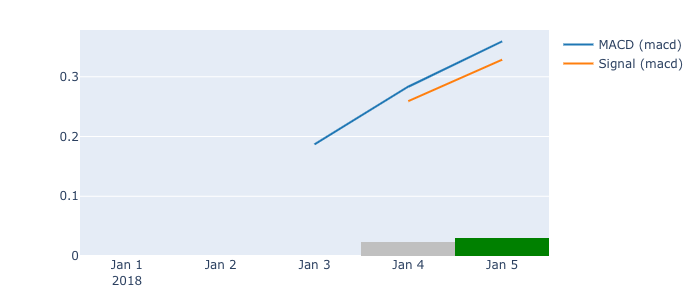

In [8]:
macd[(2, 3, 2, True, True, 'a')].plot().show_png()

## OBV

In [71]:
print(vbt.OBV.from_params(ts['a'], ts['b']).obv)
print(vbt.OBV.from_params(ts['a'], ts).obv)
print(vbt.OBV.from_params(ts, ts['b']).obv)
print(vbt.OBV.from_params(ts, ts.iloc[:, ::-1]).obv)

2018-01-01     NaN
2018-01-02     4.0
2018-01-03     7.0
2018-01-04     9.0
2018-01-05    10.0
Name: (a, b), dtype: float64
               a     b    c
2018-01-01   NaN   NaN  NaN
2018-01-02   2.0   4.0  2.0
2018-01-03   5.0   7.0  5.0
2018-01-04   9.0   9.0  7.0
2018-01-05  14.0  10.0  8.0
               a     b    c
2018-01-01   NaN   NaN  NaN
2018-01-02   4.0  -4.0  4.0
2018-01-03   7.0  -7.0  7.0
2018-01-04   9.0  -9.0  5.0
2018-01-05  10.0 -10.0  4.0
              a     b    c
              c     b    a
2018-01-01  NaN   NaN  NaN
2018-01-02  2.0  -4.0  2.0
2018-01-03  5.0  -7.0  5.0
2018-01-04  7.0  -9.0  1.0
2018-01-05  8.0 -10.0 -4.0


In [72]:
%timeit vbt.OBV.from_params(big_ts, big_ts.iloc[:, ::-1])

print(vbt.OBV.from_params(big_ts, big_ts.iloc[:, ::-1]).obv.shape)

17.7 ms ± 55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(1000, 1000)


In [73]:
obv = vbt.OBV.from_params(ts, ts.iloc[:, ::-1])

print(obv.obv)

              a     b    c
              c     b    a
2018-01-01  NaN   NaN  NaN
2018-01-02  2.0  -4.0  2.0
2018-01-03  5.0  -7.0  5.0
2018-01-04  7.0  -9.0  1.0
2018-01-05  8.0 -10.0 -4.0


In [74]:
print(obv.obv_above([0, 5], multiple=True))

obv_above       0                    5              
                a      b      c      a      b      c
                c      b      a      c      b      a
2018-01-01  False  False  False  False  False  False
2018-01-02   True  False   True  False  False  False
2018-01-03   True  False   True  False  False  False
2018-01-04   True  False   True   True  False  False
2018-01-05   True  False  False   True  False  False


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/combine_fns.py:98: RuntimeWarning:

invalid value encountered in greater



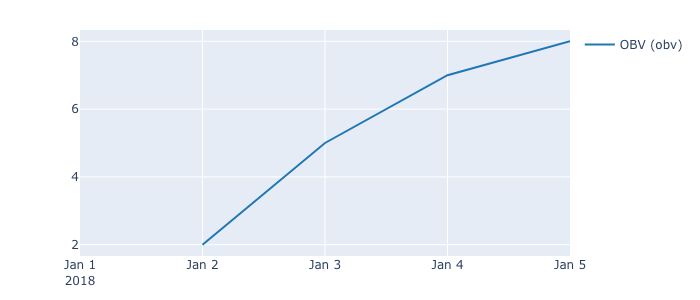

In [75]:
obv[('a', 'c')].plot().show_png()

## ATR

In [76]:
print(vbt.ATR.from_params(ts['a'], ts['a']*1.1, ts['a']*0.9, window=2).atr)
print(vbt.ATR.from_params(ts, ts['a']*1.1, ts['a']*0.9, window=2).atr)
print(vbt.ATR.from_params(ts, ts*1.1, ts*0.9, window=[2, 3]).atr)
print(vbt.ATR.from_params(ts, ts*1.1, ts*0.9, window=[2, 3], ewm=[False, True], param_product=True).atr)

2018-01-01         NaN
2018-01-02    0.950000
2018-01-03    1.192308
2018-01-04    1.332500
2018-01-05    1.444628
Name: (2, True, a), dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.950000  2.450000  0.950000
2018-01-03  1.192308  1.653846  1.192308
2018-01-04  1.332500  1.482500  1.332500
2018-01-05  1.444628  2.833058  2.783471
atr_window         2                             3                    
atr_ewm         True                          True                    
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02  0.950000  1.300000  0.950000       NaN       NaN       NaN
2018-01-03  1.192308  1.300000  1.192308  1.114286  1.285714  1.114286
2018-01-04  1.332500  1.232500  1.197500  1.266667  1.240000  1.160000
2018-01-05  1.444628  1.143802  1.132231  1.387097  1.167742  1.129032
atr_window     2                    

In [77]:
# One window
%timeit vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=2)

print(vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=2).atr.shape)

623 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [78]:
# Multiple windows
%timeit vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.arange(2, 100)) # rolling min/max very expensive

print(vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.arange(2, 100)).atr.shape)

4.27 s ± 48.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [79]:
# One window repeated
%timeit vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.full(100, 2))

print(vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.full(100, 2)).atr.shape)

2.74 s ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [80]:
atr = vbt.ATR.from_params(ts, ts*1.1, ts*0.9, window=[2, 3], ewm=[False, True])

print(atr.tr)
print(atr.atr)

atr_window     2               3          
atr_ewm    False           True           
               a    b    c     a    b    c
2018-01-01   0.2  1.0  0.2   0.2  1.0  0.2
2018-01-02   1.2  1.4  1.2   1.2  1.4  1.2
2018-01-03   1.3  1.3  1.3   1.3  1.3  1.3
2018-01-04   1.4  1.2  1.2   1.4  1.2  1.2
2018-01-05   1.5  1.1  1.1   1.5  1.1  1.1
atr_window     2                     3                    
atr_ewm    False                 True                     
               a     b     c         a         b         c
2018-01-01   NaN   NaN   NaN       NaN       NaN       NaN
2018-01-02  0.70  1.20  0.70       NaN       NaN       NaN
2018-01-03  1.25  1.35  1.25  1.114286  1.285714  1.114286
2018-01-04  1.35  1.25  1.25  1.266667  1.240000  1.160000
2018-01-05  1.45  1.15  1.15  1.387097  1.167742  1.129032


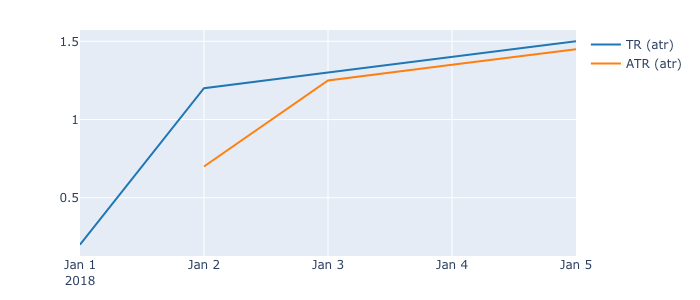

In [81]:
atr[(2, False, 'a')].plot().show_png()